In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
import functools
import inspect
import emcee


In [2]:
def gauss_model(x_data, params):
    A, mu, sigma, a, b = params
    bkg = a * x_data + b
    gauss_model = A * np.exp(-0.5 * ((x_data - mu) / sigma) ** 2)
    return bkg + gauss_model

In [3]:
mu_bounds = (1500, 2250)
def log_prior(A, mu, sigma, a, b):
    if 0 < A < 1e5 and mu_bounds[0] < mu < mu_bounds[1] and 0 < sigma < 3 and -10 < a < 10 and -1e4 < b < 1e4:
        return 0.0  # log(1) # flat 0 prior inside bounds
    return -np.inf  # log(0)

In [4]:
def gaussian_log_likelihood(x, y, params):
    """Calculate the Gaussian log-likelihood for given data."""
    #Assuming background is not removed 
    A, mu, sigma, a, b = params
    y_model = gauss_model(x, A, mu, sigma, a, b)
    
    residuals = ((y - y_model) / (len(x)))**2
    logL = -0.5 * np.sum(residuals)# + np.log(2 * np.pi)) # only needs to be portional
    return logL

In [ ]:
def gaussian_log_likelihood(x, A, mu, sigma, a, b):
    """Calculate the Gaussian log-likelihood for given data."""
    """ P(params|prior) """
    # Validate parameters
    if b < 0 or sigma <= 0 or A < 0:
        return -np.inf
    if mu < mu_bounds[0] or mu > mu_bounds[1]:
        return -np.inf
    
    y_model = gauss_model(x, A, mu, sigma, a, b)
    residuals = (y_model)**2
    logL = -0.5 * np.sum(residuals)# + np.log(2 * np.pi * (len(x))**2)) # only needs to be portional
    return logL

In [6]:
def log_posterior( x, pri_A, pri_mu, pri_sigma, pri_a, pri_b):
    """Calculate the log-posterior for given data and parameters."""
    """log(P(data|params)) + P(params|prior)"""
    lp = log_prior(pri_A, pri_mu, pri_sigma, pri_a, pri_b)
    if not np.isfinite(lp):
        return -np.inf
    ll = gaussian_log_likelihood(x, pri_A, pri_mu, pri_sigma, pri_a, pri_b)
    return lp + ll

In [7]:

def wrap(func, **kwargs):
    """Prepare an arbitrary function to use with emcee sampling.

    Emcee expects its parameters in a single list, but it is sometimes more
    convenient to write a function in terms of named parameters and
    hyperparameters. This method uses introspection to wrap an arbitrary
    function with named parameters so that it has the signature expected
    by emcee.

    For example:

        def f(x,y,a,b): ...
        wrap(f, x=[1], y=[2], a=3, b=4, c=3, d=4)

    returns a tuple (wrapped, ['x','y'], [1,2], {'c':3, 'd':4}) where:

      - wrapped([p,q]) calls f(x=p,y=q,a=3,b=4)
      - [1,2] are the initial values to use for parameters named ['x','y'].
      - {'c':3, 'd':4} are the input kwargs with args of f() removed.

    The square brackets identify floating arguments and specify their initial
    value. An optional callable to evaluate a log-prior can also be passed,
    for example:

        wrap(f, x=[1,px], y=[2,py], a=3, b=4, c=3, d=4)

    where px(x) and py(y) return the (un-normalized) log of the priors on
    x and y to use during posterior sampling.

    Parameters
    ----------
    func : callable
        The function that should be prepared. It is assumed to have only
        numerical arguments that accept any floating point values.
    **kwargs : keyword arguments
        All arguments of func must be included and assigned a value.
        Arguments assigned a floating point value are considered fixed
        during sampling.  Arguments assigned a floating point value
        within a list, e.g., [1.2], will be sampled using the initial
        value provided.  Sampled arguments can optionally also specify
        a log-prior distribution using, e.g. [1.2, lnprior], where lnprior
        is a function of the sampled argument that returns the log prior
        probability density (which does not need to be normalized).

    Returns
    -------
    tuple
        Tuple (wrapped, names, values, kwargs). See example above for details.
    """
    fixed = {}
    names, values, lnpriors = [], [], []
    funcsig = inspect.signature(func)
    try:
        funcargs = {name: kwargs[name] for name in funcsig.parameters}
    except KeyError:
        raise ValueError('Missing arguments.')
    bound = funcsig.bind(**funcargs)
    bound.apply_defaults()
    NoPrior = lambda x: 0.
    for name, value in bound.arguments.items():
        if isinstance(value, list):
            names.append(name)
            values.append(value.pop(0))
            lnpriors.append(value.pop(0) if value else NoPrior)
            if value:
                raise ValueError('Invalid syntax for argument {}.'.format(name))
        else:
            fixed[name] = value
    partial = functools.partial(func, **fixed)
    def wrapped(theta):
        if len(theta) != len(names):
            raise ValueError('expected list of {} values.'.format(len(names)))
        result = 0.
        for lnprior, value in zip(lnpriors, theta):
            result += lnprior(value)
            if not np.isfinite(result):
                # theta is not allowed by this prior.
                return -np.inf
        args = dict(zip(names, theta))
        result += partial(**args)
        return result
    # Remove function args from kwargs.
    for name in funcargs:
        kwargs.pop(name, None)
    return wrapped, names, values, kwargs


def sample(func, names, values, nwalkers=20, nsamples=1000, abs_rms=1e-4,
           frac_rms=1e-3, burnin=100, random_state=None):
    """Generate MCMC samples of the un-normalized PDF func() using emcee.

    Can be used standalone but intended to work with :func:`wrap`.

    Initial values for each walker are Gaussian samples centered on the
    input values with an RMS of max(abs_rms, frac_rms * values).

    Parameters
    ----------
    func : callable
        Evaluate the log PDF to sample. Passed a single list of parameter
        values. Can be prepared using :func:`wrap`.
    names : iterable
        List of names for each floating parameter.  Used to label columns
        in the returned DataFrame. Can be prepared using :func:`wrap`.
    values : iterable
        List of initial values for each floating parameter.  Used to center
        random initial values for each walker. Can be prepared using
        :func:`wrap`.
    nwalkers : int
        The number of emcee walkers to use.
    nsamples : int
        The total number of samples to return, after combining walkers
        and trimming initial burnin.
    abs_rms : float
        Used to set walker initial values.  See above for details.
    rel_rms : float
        Used to set walker initial values.  See above for details.
    burnin : int
        The number of samples to remove from each walker's chain.
    random_state : np.random.RandomState or None
        The random state to use for reproducible chains.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, using the inputs names for columns.
    """
    if random_state is None:
        random_state = np.random.RandomState()
    # Generate sampler starting points.
    ndim = len(names)
    values = np.array(values, float)
    initial = np.tile(values, (nwalkers, 1))
    rms = np.maximum(abs_rms, frac_rms * values)
    initial += rms * random_state.normal(size=(nwalkers, ndim))
    # Initialize and run sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
    n_per_chain = 1 + nsamples // nwalkers + burnin
    sampler.run_mcmc(initial, n_per_chain, rstate0=random_state.get_state())
    # Remove burnin and return results in a DataFrame.
    chain = sampler.chain[:, burnin:].reshape(-1, ndim)[:nsamples]
    return pd.DataFrame(chain, columns=names)


def MCMC_sample(func, **kwargs):
    """Generate random samples from an un-normalized PDF.

    See :func:`wrap` and :func:`sample` for details.

    Parameters
    ----------
    func : callable
        Function to evaluate log(f(...)) where f(...) is proportional
        to the desired probability density.  Will be wrapped to
        determine which arguments are sampled and which are fixed.
    **kwargs : keyword arguments
        Used to configure the wrapping of func and the sampler.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, with one named column per
        sampled argument of the input function.
    """
    # Wrap the input function.
    wrapped, names, values, kwargs = wrap(func, **kwargs)
    # Generate emcee samples.
    return sample(wrapped, names, values, **kwargs)

In [8]:
delta = 6
def MCMC_rate_learn_plot(data, param_expected, param_priors, seed=123):
    A_prior, mu_prior, sigma_prior, a_prior, b_prior = param_priors
    # Generate some random decays using the true decay rate.
    gen = np.random.RandomState(seed=seed)
    initialx = scipy.stats.uniform.rvs(loc=1593-delta, scale=2 * delta, size=data.shape[0], random_state=gen)
    # sampley = scipy.stats.norm.pdf(samplex, loc=mu_prior, scale=sigma_prior)
    # Generate MCMC samples of the gaussian for this data with this prior.
    samples = MCMC_sample(log_posterior, x=initialx, params=param_priors, nsamples=20000)
    # Plot samples.
    plt.hist(samples['theta'], range=(1500, 2350), bins=150, density=True)
    plt.axvline(2039, c='r', ls='--')
    plt.xlabel('Decay rate $\lambda$')
    plt.xlim(1500, 2039)

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_36084/749554265.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Decay rate $\lambda$')


In [9]:
data = pd.read_csv('../data/testA_rmvdbkg.csv')

In [10]:
MCMC_rate_learn_plot(data, param_expected=(70, 1593, 1, 0, 0), param_priors=(70, 1593, 1, 0, 0) )

/tmp/ipykernel_36084/749554265.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Decay rate $\lambda$')


ValueError: Missing arguments.

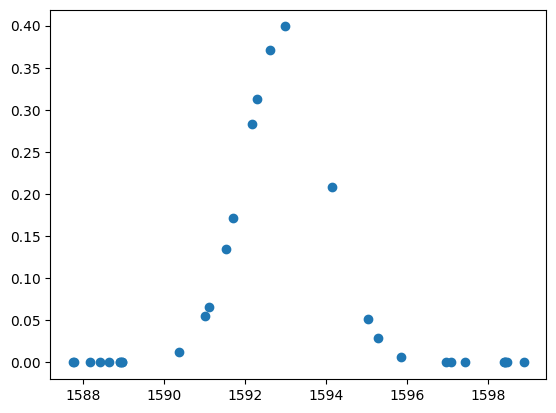

In [ ]:
x = scipy.stats.uniform.rvs(loc=1593-delta, scale=2*delta, size=data.shape[0])
y = scipy.stats.norm.pdf(x, loc=1593, scale=1)
plt.scatter(x, y)